In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, 
    roc_auc_score, confusion_matrix, 
    classification_report,mean_squared_error, 
    mean_absolute_error, r2_score,
    make_scorer
)
import joblib

# Two step model

## Clasificación binaria (pagada a tiempo / tarde)

In [3]:
dataset = pd.read_pickle("../data/dataset_final.pkl")

In [4]:
dataset.describe()

,id,company_id,currency_id,invoice_date,invoice_date_due,payment_dates,amount_total_eur,amount_residual_eur,payment_overdue_days,term,...,ratio_invoice_amount_late_prior,avg_delay_prior_late_invoices,avg_delay_prior_all,num_outstanding_invoices,num_outstanding_invoices_late,ratio_outstanding_invoices_late,total_invoice_amount_outstanding,total_invoice_amount_outstanding_late,ratio_invoice_amount_outstanding_late,avg_payment_term_prior_invoices
count,10002.000000,10002.000000,10002.000000,10002,10002,10002,10002.000000,10002.000000,10002.000000,10002.000000,...,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000
mean,90365.012997,4.925715,5.085183,2024-01-03 04:38:52.333533440,2024-02-18 09:44:40.023995392,2024-02-28 05:27:14.793041408,5136.368080,0.000607,17.527794,46.212957,...,0.520429,27.196449,20.251081,0.117876,0.117876,0.057289,414.755628,414.755628,0.057289,36.562253
min,1033.000000,1.000000,1.000000,2022-09-05 00:00:00,2022-10-13 00:00:00,2023-01-02 00:00:00,0.150000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49311.750000,3.000000,1.000000,2023-06-30 00:00:00,2023-08-09 00:00:00,2023-08-28 06:00:00,564.007298,0.000000,0.000000,30.000000,...,0.063094,1.326087,0.438923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.612245
50%,90853.500000,3.000000,1.000000,2024-01-02 00:00:00,2024-02-29 00:00:00,2024-03-07 00:00:00,2117.500000,0.000000,1.000000,50.000000,...,0.587763,12.305556,5.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000
75%,130463.750000,7.000000,1.000000,2024-06-30 18:00:00,2024-08-29 00:00:00,2024-09-04 00:00:00,5374.767451,0.000000,17.000000,60.000000,...,0.964912,35.789474,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.175373
max,178471.000000,14.000000,33.000000,2024-12-31 00:00:00,2025-03-15 00:00:00,2025-03-13 00:00:00,633574.150000,6.000000,439.000000,213.000000,...,1.000000,400.000000,400.000000,20.000000,20.000000,1.000000,71251.000000,71251.000000,1.000000,120.000000
std,48609.299665,3.185273,10.652032,NaN,NaN,NaN,12756.847524,0.059996,40.329528,21.964945,...,0.401794,43.057763,37.203141,0.791921,0.791921,0.232405,3068.207534,3068.207534,0.232405,25.742830


Recorte de los datos para quitar periodos en los que no hay apenas facturas

In [83]:
dataset = dataset[(dataset['invoice_date'] < '2025-01-01') & (dataset['invoice_date'] >= '2022-09-01')]
dataset.to_pickle("../data/dataset_final.pkl")

C:\Users\Ismae\AppData\Local\Temp\ipykernel_23664\1107383167.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  conteo_mensual = df_temporal['paid_late_binary'].resample('M').sum()


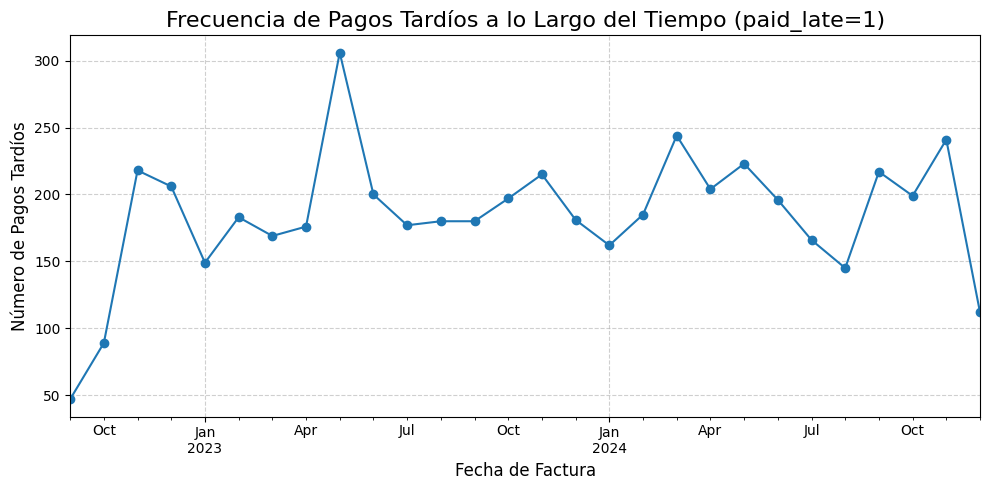

In [40]:
import matplotlib.pyplot as plt
dataset['paid_late_binary'] = dataset['paid_late'].astype(int)
columna_fecha = 'invoice_date' 
dataset[columna_fecha] = pd.to_datetime(dataset[columna_fecha])
df_temporal = dataset.set_index(columna_fecha).sort_index()
conteo_mensual = df_temporal['paid_late_binary'].resample('M').sum()
plt.figure(figsize=(10, 5))
conteo_mensual.plot(kind='line', marker='o')
plt.title('Frecuencia de Pagos Tardíos a lo Largo del Tiempo (paid_late=1)', fontsize=16)
plt.xlabel('Fecha de Factura', fontsize=12)
plt.ylabel('Número de Pagos Tardíos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [42]:
dataset['paid_late'].value_counts()

paid_late
True     5167
False    4835
Name: count, dtype: int64

In [69]:
features_classification = [
    # Identidad y Factura Actual
    'amount_total_eur', 'term_rounded', 'currency_name', 'company_name', 
    'partner_name', 'due_last_three_days_month', 'due_date_second_half_month',
    
    # Historial
    'num_prior_invoices', 
    'num_late_prior_invoices', 
    'ratio_late_prior_invoices',
    'avg_delay_prior_late_invoices', 
    'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices',
    'avg_invoiced_prior', 
    'total_invoice_amount_prior', 
    'total_invoice_amount_late_prior', 
    'ratio_invoice_amount_late_prior',
    'num_outstanding_invoices', 
    'num_outstanding_invoices_late', 
    'ratio_outstanding_invoices_late', 
    'total_invoice_amount_outstanding', 
    'total_invoice_amount_outstanding_late', 
    'ratio_invoice_amount_outstanding_late'
]

target_classification = 'paid_late'

In [70]:
X = dataset[features_classification].copy()
y = dataset[target_classification].copy()


In [73]:
y = y.astype(int)
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)

log_transform_cols = [
        'amount_total_eur', 'num_prior_invoices', 'total_invoice_amount_prior', 
        'total_invoice_amount_outstanding', 'num_outstanding_invoices', 
        'avg_invoiced_prior'
]
all_numeric_cols = [
    'amount_total_eur', 'term_rounded', 'num_prior_invoices', 'avg_delay_prior_late_invoices', 
    'total_invoice_amount_prior', 'total_invoice_amount_outstanding',
    'num_outstanding_invoices', 'num_late_prior_invoices', 'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_late_prior'
]
scaler_only_cols = [
    col for col in all_numeric_cols 
    if col not in log_transform_cols
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

categorical_features = ['currency_name', 'company_name', 'partner_name']
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_log_scale', numeric_transformer, log_transform_cols),
        ('scaler_only', StandardScaler(), scaler_only_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        #('target', TargetEncoder(), [''])
    ],
    remainder='passthrough' # Ignora cualquier columna en X que no esté en features_rfecv
)

Modelo inicial

In [74]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100, 
        max_depth=7,         
        learning_rate=0.05, 
        objective='binary:logistic', 
        n_jobs=-1, 
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1161
           1       0.66      0.75      0.70       840

    accuracy                           0.73      2001
   macro avg       0.73      0.74      0.73      2001
weighted avg       0.74      0.73      0.73      2001



In [80]:

tscv_folds = TimeSeriesSplit(n_splits=5)

selector = RFECV(
    estimator=XGBClassifier(
        n_estimators=200, 
        max_depth=5,         
        learning_rate=0.05, 
        objective='binary:logistic', 
        n_jobs=-1, 
        random_state=42
    ),        
    step=1,                         
    cv=tscv_folds,                     
    scoring= 'f1',   
    n_jobs=-1                        
)

categorical_to_drop = ['currency_name', 'company_name', 'partner_name']

X_simple = X.drop(columns=categorical_to_drop)

selector.fit(X_simple, y) 

print(f"Número óptimo de características: {selector.n_features_}")
best_index = selector.n_features_ - 1
best_score = selector.cv_results_['mean_test_score'][best_index]
print(f"Rendimiento del modelo (f1): {best_score:.4f}")

selected_features_mask = selector.support_
selected_features = X_simple.columns[selected_features_mask].tolist()

print("\nCaracterísticas Seleccionadas:")
print(selected_features)

Número óptimo de características: 15
Rendimiento del modelo (f1): 0.7495

Características Seleccionadas:
['amount_total_eur', 'term_rounded', 'due_last_three_days_month', 'due_date_second_half_month', 'num_prior_invoices', 'num_late_prior_invoices', 'ratio_late_prior_invoices', 'avg_delay_prior_late_invoices', 'avg_delay_prior_all', 'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_prior', 'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior', 'total_invoice_amount_outstanding']


## Filtrado

In [84]:
dataset = pd.read_pickle("../data/dataset_final.pkl")

In [88]:
rfecv_features = [
    'amount_total_eur', 'term_rounded', 'due_last_three_days_month',
    'due_date_second_half_month', 'num_prior_invoices', 'num_late_prior_invoices',
    'ratio_late_prior_invoices', 'avg_delay_prior_late_invoices', 'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_prior', 
    'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior', 'total_invoice_amount_outstanding'
    ,'company_name', 'partner_name', 'currency_name']
target_classification = 'paid_late'

In [89]:
X = dataset[rfecv_features].copy()
y = dataset[target_classification].copy()

In [90]:
y = y.astype(int)
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)

log_transform_cols = [
        'amount_total_eur', 'num_prior_invoices', 'total_invoice_amount_prior', 
        'total_invoice_amount_outstanding', 
        'avg_invoiced_prior'
]
all_numeric_cols = [
    'amount_total_eur', 'term_rounded', 'num_prior_invoices', 'avg_delay_prior_late_invoices', 
    'total_invoice_amount_prior', 'total_invoice_amount_outstanding',
    'num_late_prior_invoices', 'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_late_prior'
]
scaler_only_cols = [
    col for col in all_numeric_cols 
    if col not in log_transform_cols
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

categorical_features = ['currency_name', 'company_name', 'partner_name']
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_log_scale', numeric_transformer, log_transform_cols),
        ('scaler_only', StandardScaler(), scaler_only_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        #('target', TargetEncoder(), [''])
    ],
    remainder='passthrough'
)

In [ ]:
params= {
    'subsample': 0.9, 'reg_lambda': 10,
    'reg_alpha': 0.001, 'n_estimators': 100,
    'min_child_weight': 7, 'max_depth': 10,
    'learning_rate': 0.02, 'grow_policy': 'depthwise',
    'gamma': 0.5, 'colsample_bytree': 0.8,
    'colsample_bylevel': 0.7}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        **params,
        objective='binary:logistic', 
        n_jobs=-1, 
        random_state=10
    ))
])


tscv_folds = TimeSeriesSplit(n_splits=5)

f1_scores = []
accuracy_scores = []
for train_index, test_index in tscv_folds.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model_pipeline.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_pipeline.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    accuracy = accuracy_score(y_test_fold, y_pred_fold)

    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
print(f"F1 Score promedio en TimeSeriesSplit: {np.mean(f1_scores):.4f}")
print(f"Accuracy promedio en TimeSeriesSplit: {np.mean(accuracy_scores):.4f}")

F1 Score promedio en TimeSeriesSplit: 0.7732
Accuracy promedio en TimeSeriesSplit: 0.7706


In [121]:
filename_classifier = '../models/modelo_clasificador_paso1.pkl'
joblib.dump(model_pipeline, filename_classifier)

['../models/modelo_clasificador_paso1.pkl']

### RandomGridCV

In [114]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500, 800, 1000, 1500, 2000],
    'classifier__learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15], 
    'classifier__min_child_weight': [1, 3, 5, 7, 10, 15, 20, 50, 100], 
    'classifier__gamma': [0, 0.1, 0.5, 1, 2, 5, 10], 
    'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100], 
    'classifier__reg_lambda': [0.1, 1, 5, 10, 20, 50, 100],          
    'classifier__grow_policy': ['depthwise', 'lossguide'],
}
tscv = TimeSeriesSplit(n_splits=5) 

n_iterations = 500 

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_grid,
    n_iter=n_iterations,         
    scoring='f1',
    cv=tscv,
    verbose=1,
    random_state=10,              
    n_jobs=-2
)

random_search.fit(X, y)

print(f"Mejor F1: {random_search.best_score_:.4f}")
print("Mejores Parámetros:")
print(random_search.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


KeyboardInterrupt: 

In [122]:
dataset_paid_late = dataset[dataset['paid_late'] == 1]

In [123]:
features_reg = [
    # Identidad y Factura Actual
    'amount_total_eur', 'term_rounded', 'currency_name', 'company_name', 
    'partner_name', 'due_last_three_days_month', 'due_date_second_half_month',
    
    # Historial
    'num_prior_invoices', 
    'num_late_prior_invoices', 
    'ratio_late_prior_invoices',
    'avg_delay_prior_late_invoices', 
    'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices',
    'avg_invoiced_prior', 
    'total_invoice_amount_prior', 
    'total_invoice_amount_late_prior', 
    'ratio_invoice_amount_late_prior',
    'num_outstanding_invoices', 
    'num_outstanding_invoices_late', 
    'ratio_outstanding_invoices_late', 
    'total_invoice_amount_outstanding', 
    'total_invoice_amount_outstanding_late', 
    'ratio_invoice_amount_outstanding_late'
]

target_classification = 'payment_overdue_days'

In [124]:
X_reg = dataset_paid_late[features_reg].copy()
y_reg = dataset_paid_late[target_classification].copy()

In [130]:
y_reg = np.log1p(y_reg)

In [142]:
y = y.astype(int)
X['due_last_three_days_month'] = X['due_last_three_days_month'].astype(int)
X['due_date_second_half_month'] = X['due_date_second_half_month'].astype(int)

log_transform_cols = [
        'amount_total_eur', 'num_prior_invoices', 'total_invoice_amount_prior', 
        'total_invoice_amount_outstanding', 'num_outstanding_invoices', 
        'avg_invoiced_prior', 'num_outstanding_invoices_late', 'total_invoice_amount_outstanding_late'
]
all_numeric_cols = [
    'amount_total_eur', 'term_rounded', 'num_prior_invoices', 'avg_delay_prior_late_invoices', 
    'total_invoice_amount_prior', 'total_invoice_amount_outstanding',
    'num_outstanding_invoices', 'num_late_prior_invoices', 'avg_delay_prior_all', 
    'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_late_prior'
]
scaler_only_cols = [
    col for col in all_numeric_cols 
    if col not in log_transform_cols
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

categorical_features = ['currency_name', 'company_name']
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_log_scale', numeric_transformer, log_transform_cols),
        ('scaler_only', StandardScaler(), scaler_only_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('target', TargetEncoder(), ['partner_name'])
    ],
    remainder='passthrough' 
)

In [143]:
params = {
    'subsample': 0.7, 'reg_lambda': 1, 
    'reg_alpha': 20, 'n_estimators': 600, 
    'min_child_weight': 10, 'max_depth': 12, 
    'learning_rate': 0.01, 'gamma': 0.1, 
    'colsample_bytree': 0.8
}

reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor(
        objective='reg:squarederror',
        **params,
        n_jobs=-2, 
        random_state=46
    ))
])

tscv = TimeSeriesSplit(n_splits=5) 


r2_scores = cross_val_score(
    reg_model, 
    X_reg, 
    y_reg, 
    cv=tscv, 
    scoring='r2', 
    n_jobs=-1
)

print(f"R^2 Score (5-Fold CV Media): {r2_scores.mean():.4f}")

R^2 Score (5-Fold CV Media): 0.2520


In [140]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score

tscv_folds = TimeSeriesSplit(n_splits=5)

reg_model_solo = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,   
    max_depth=10,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

selector = RFECV(
    estimator=reg_model_solo,        
    step=1,                         
    cv=tscv_folds,                     
    scoring=make_scorer(r2_score),   
    n_jobs=-2                       
)


print("Iniciando Búsqueda Recursiva de Características (RFECV)... Esto tomará tiempo.")
categorical_to_drop = ['currency_name', 'company_name', 'partner_name']

X_simple = X_reg.drop(columns=categorical_to_drop)

selector.fit(X_simple, y_reg) 

print(f"Número óptimo de características: {selector.n_features_}")
best_index = selector.n_features_ - 1

best_score = selector.cv_results_['mean_test_score'][best_index]
print(f"Rendimiento del modelo con el subconjunto óptimo (R2 CV score): {best_score:.4f}")

selected_features_mask = selector.support_
selected_features = X_simple.columns[selected_features_mask].tolist()

print("\nCaracterísticas Seleccionadas:")
print(selected_features)

Iniciando Búsqueda Recursiva de Características (RFECV)... Esto tomará tiempo.
Número óptimo de características: 13
Rendimiento del modelo con el subconjunto óptimo (R2 CV score): 0.1602

Características Seleccionadas:
['term_rounded', 'due_last_three_days_month', 'num_late_prior_invoices', 'ratio_late_prior_invoices', 'avg_delay_prior_late_invoices', 'avg_delay_prior_all', 'avg_payment_term_prior_invoices', 'avg_invoiced_prior', 'total_invoice_amount_prior', 'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior', 'num_outstanding_invoices', 'total_invoice_amount_outstanding']


Paso intermedio (nuevas features)

In [ ]:
reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,    # Menos árboles para que RFECV sea más rápido
        max_depth=10,
        learning_rate=0.05,
        n_jobs=-2, 
        random_state=42
    ))
])


param_grid = {
    'classifier__n_estimators': [200, 400, 600, 800, 1000],  
    'classifier__max_depth': [5, 7, 9, 12, 15],          
    'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'classifier__reg_alpha': [0, 1, 5, 10, 20],
    'classifier__reg_lambda': [1, 5, 10, 20, 50],
    'classifier__gamma': [0, 0.1, 0.5, 1.0],
    'classifier__min_child_weight': [1, 5, 10, 20],
}
r2_scorer = make_scorer(r2_score)
tscv = TimeSeriesSplit(n_splits=5) 


n_iterations = 200 

random_search = RandomizedSearchCV(
    estimator=reg_model,
    param_distributions=param_grid,
    n_iter=n_iterations,         
    scoring=r2_scorer,
    cv=tscv,
    verbose=1,
    random_state=42,              
    n_jobs=-2
)

print(f"Iniciando Búsqueda de Hiperparámetros (RandomizedSearch) probando {n_iterations} combinaciones...")

random_search.fit(X, y)


print(f"Mejor R^2 encontrado: {random_search.best_score_:.4f}")
print("Mejores Parámetros:")
print(random_search.best_params_)